#### COVID-19 Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopy
import math

import sklearn as sk

from datetime import datetime

In [2]:
full_data = pd.read_csv("../data/full_data_mar_18.csv")
full_data = full_data.fillna(0)
sl_data = pd.read_csv("../data/COVID-19_SL_Mar_19.csv", skiprows=1,
                      names=["date","new_cases","total_cases","new_deaths","total_deaths"])
sl_data.head()

,date,new_cases,total_cases,new_deaths,total_deaths
0,27-01-2020,1,1,0,0
1,28-01-2020,0,1,0,0
2,29-01-2020,0,1,0,0
3,30-01-2020,0,1,0,0
4,31-01-2020,0,1,0,0


#### Filter Data for Sri Lanka

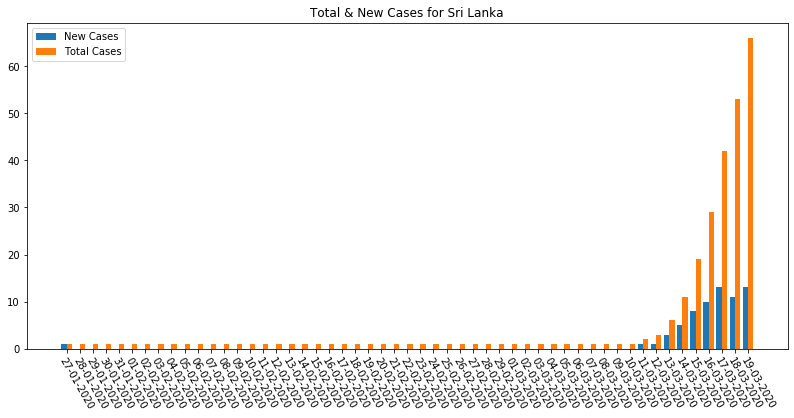

In [3]:
sl_data = sl_data[sl_data['total_cases'] > 0]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(sl_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(sl_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Sri Lanka")
ax.bar(x_ind, 'new_cases', width, data = sl_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = sl_data, label = "Total Cases")
ax.legend()
plt.show()

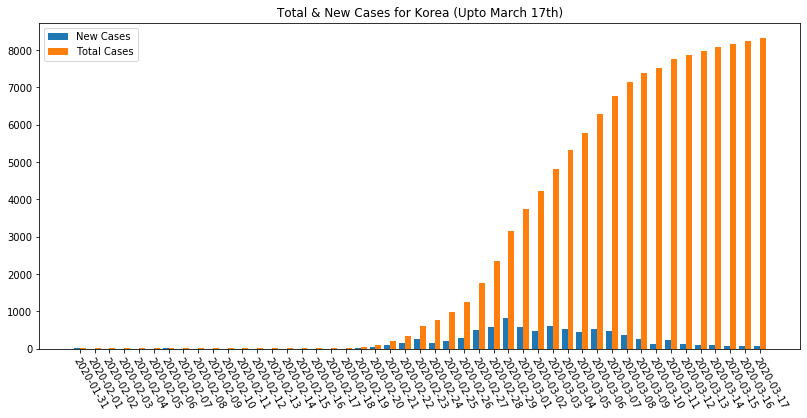

In [4]:
korea_data = full_data[(full_data['location'] == "South Korea") & (full_data['total_cases'] > 10)]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(korea_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(korea_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Korea (Upto March 17th)")

ax.bar(x_ind, 'new_cases', width, data = korea_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = korea_data, label = "Total Cases")
ax.legend()
plt.show()

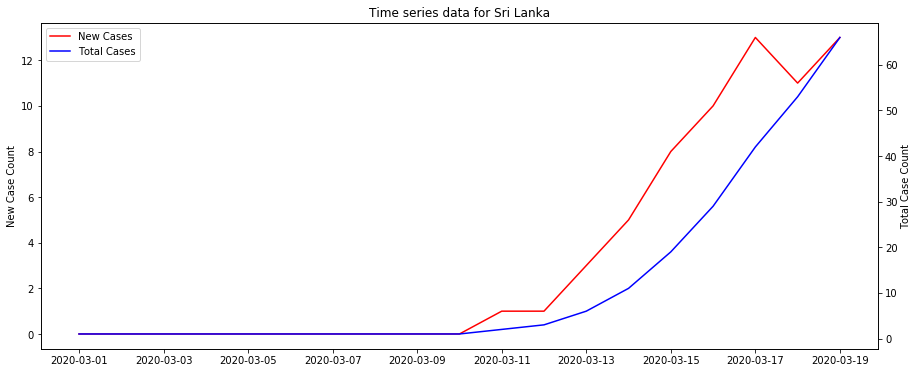

In [5]:
ts_sl_data = sl_data.copy()
ts_sl_data['date'] = pd.to_datetime(ts_sl_data['date'], dayfirst=True)
ts_sl_data.set_index('date', inplace=True)
ts_sl_data = ts_sl_data.loc['2020-03-01':'2020-03-19'].asfreq('D')

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

ln1 = ax1.plot(ts_sl_data['new_cases'], color = 'r', label = "New Cases")
ln2 = ax2.plot(ts_sl_data['total_cases'], color = 'b', label = "Total Cases")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

ax1.set_ylabel("New Case Count")
ax2.set_ylabel("Total Case Count")
plt.title("Time series data for Sri Lanka")
plt.show()

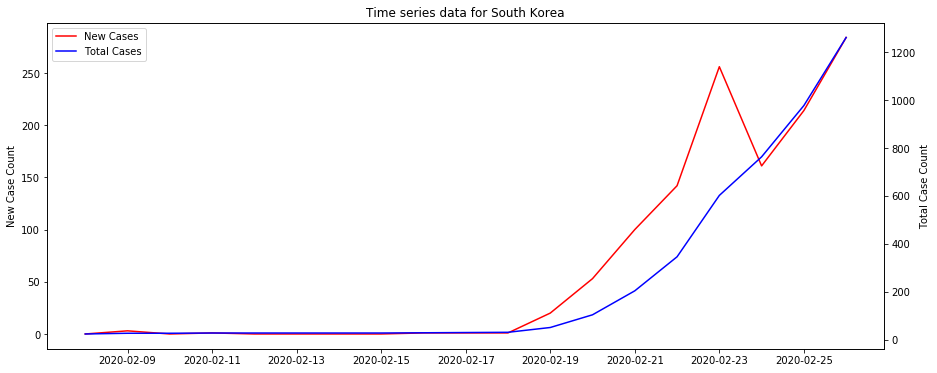

In [6]:
interim_korea_data = korea_data.copy()
interim_korea_data['new_cases'] = interim_korea_data['new_cases'].astype(int)
interim_korea_data['date'] = pd.to_datetime(interim_korea_data['date'])
interim_korea_data.set_index('date', inplace=True)
ts_korea_data = interim_korea_data.loc['2020-02-08':'2020-02-26'].asfreq('D')

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

ln1 = ax1.plot(ts_korea_data['new_cases'], color = 'r', label = "New Cases")
ln2 = ax2.plot(ts_korea_data['total_cases'], color = 'b', label = "Total Cases")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

ax1.set_ylabel("New Case Count")
ax2.set_ylabel("Total Case Count")
plt.title("Time series data for South Korea")
plt.show()

In [7]:
import itertools
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

def check_ts_stationarity(ts_data, w_size):
    rolmean = ts_data.rolling(w_size).mean()
    rolstd = ts_data.rolling(w_size).std()
    plt.figure(figsize=(15,6))
    plt.plot(ts_data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation (New Cases)')
    plt.show()
    
    decomposition = sm.tsa.seasonal_decompose(ts_data, model='additive')
    fig = decomposition.plot()
    fig.set_size_inches(12,15)
    axes = fig.get_axes()
    for ax in axes:
        ax.set_xticks(ts_data.index)
        ax.set_xticklabels(ts_data.index.date, rotation=-60, rotation_mode='anchor', ha='left')
    fig.tight_layout(pad=2.0)
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts_data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

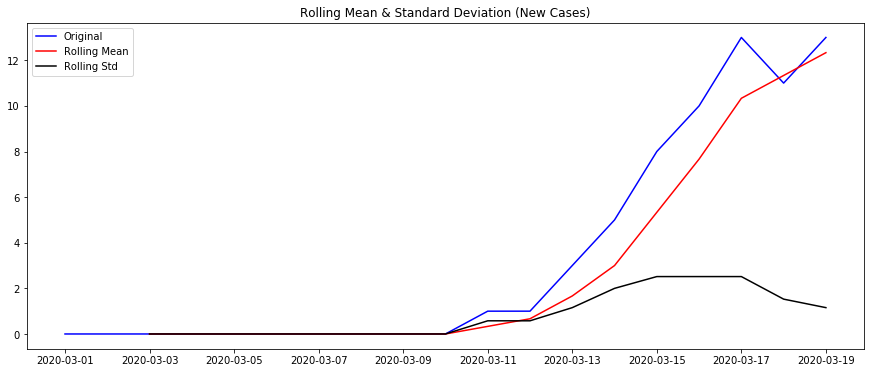

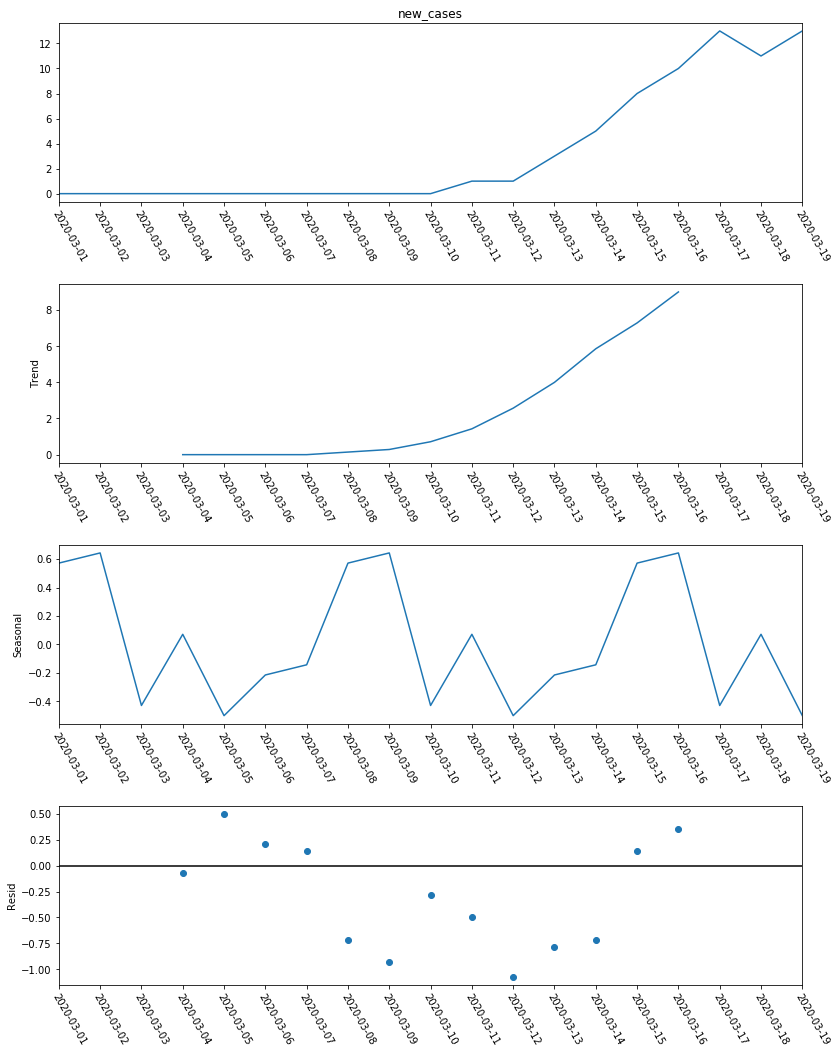

Results of Dickey-Fuller Test:
Test Statistic                  2.658137
p-value                         0.999084
#Lags Used                      7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [8]:
ts_sl = ts_sl_data['new_cases']
ts_korea = ts_korea_data['new_cases']
check_ts_stationarity(ts_sl, 3)

In [9]:
num_index = np.arange(len(ts_sl))
exog_oos_korea = interim_korea_data['new_cases'].loc['2020-02-27':'2020-03-03'].asfreq('D')
ts_sl_num_index = ts_sl_data.set_index(num_index)['new_cases']
ts_korea_num_index = ts_korea_data.set_index(num_index)['new_cases']
exog_oos_korea

date
2020-02-27    505
2020-02-28    571
2020-02-29    813
2020-03-01    586
2020-03-02    476
2020-03-03    600
Freq: D, Name: new_cases, dtype: int64

In [10]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

sel = ar_select_order(ts_sl_num_index, 7, glob=True, exog=ts_korea_num_index)
sel.ar_lags
res_ar = sel.model.fit()
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                             
===============================================================================
Dep. Variable:               new_cases   No. Observations:                   19
Model:             Restr. AutoReg-X(7)   Log Likelihood                  -0.485
Method:                Conditional MLE   S.D. of innovations              0.252
Date:                 Sat, 21 Mar 2020   AIC                             -1.424
Time:                         10:37:27   BIC                             -1.100
Sample:                              7   HQIC                            -1.543
                                    19                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.2576      0.114      2.264      0.024       0.035       0.481
new_cases.L2     0.8340      0.182      4.594      0.000       0.478       1.190
new_cases.L3     0.5078      0.259      1.957      0.050      -0.001       1.016
new_cases.L5    -4.6203      0.476     -9.716      0.000      -5.552      -3.688
new_cases.L6     2.6840      0.474      5.661      0.000       1.755       3.613
new_cases.L7     2.2621      0.944      2.395      0.017       0.411       4.113
new_cases        0.0339      0.003     12.167      0.000       0.028       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6782           -0.0000j            0.6782           -0.5000
AR.2           -0.2846           -0.6575j            0.7164           -0.3150
AR.3           -0.2846           +0.6575j            0.7164            0.3150
AR.4            0.6332           -0.4903j            0.8008           -0.1049
AR.5            0.6332           +0.4903j            0.8008            0.1049
AR.6            0.9281           -0.0000j            0.9281           -0.0000
AR.7           -2.1337           -0.0000j            2.1337           -0.5000
-----------------------------------------------------------------------------
"""

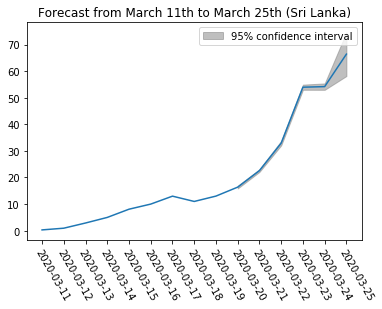

In [22]:
fig = res_ar.plot_predict(10, 24, exog_oos=exog_oos_korea)
pred_date_range = pd.date_range('2020-03-11','2020-03-25', freq='1D').date
ax = fig.get_axes()
ax[0].set_xticks(np.arange(10,25))
ax[0].set_xticklabels(pred_date_range, rotation=-60, rotation_mode='anchor', ha='left')
plt.title("Forecast from March 11th to March 25th (Sri Lanka)")
plt.show()

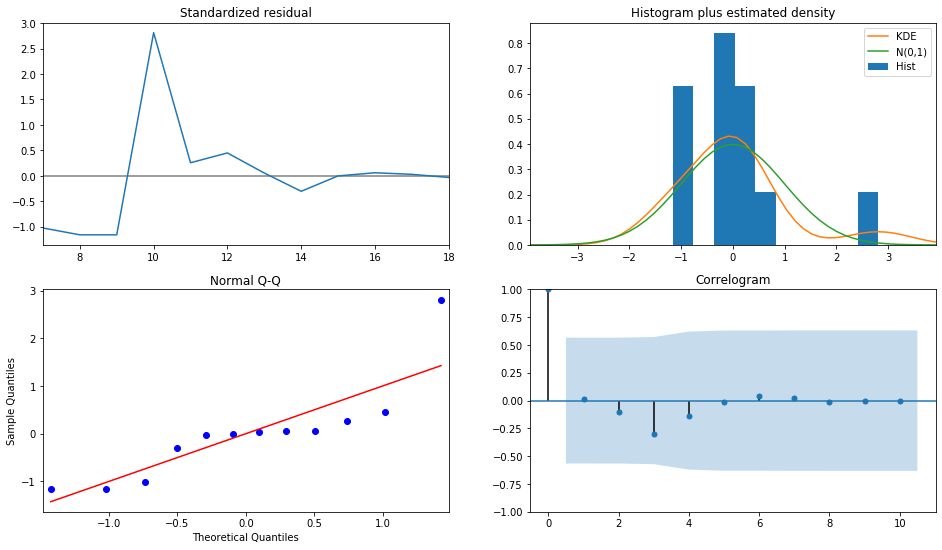

In [12]:
fig = plt.figure(figsize=(16,9))
fig = res_ar.plot_diagnostics(fig=fig, lags=10)

In [25]:
fcast = res_ar.predict(start=10, end=24, exog_oos=exog_oos_korea)
fcast.index = pred_date_range
round(fcast).astype(int)

2020-03-11     0
2020-03-12     1
2020-03-13     3
2020-03-14     5
2020-03-15     8
2020-03-16    10
2020-03-17    13
2020-03-18    11
2020-03-19    13
2020-03-20    16
2020-03-21    23
2020-03-22    33
2020-03-23    54
2020-03-24    54
2020-03-25    66
dtype: int64